In [1]:
# Part 1

import numpy as np
import pandas as pd

from pylab import mpl, plt

import scipy.optimize as sco

raw = pd.read_csv('https://raw.githubusercontent.com/aaiken1/fin-data-analysis-python/main/data/etf-reproducible-finance.csv',
                  index_col=0, parse_dates=True).dropna() 

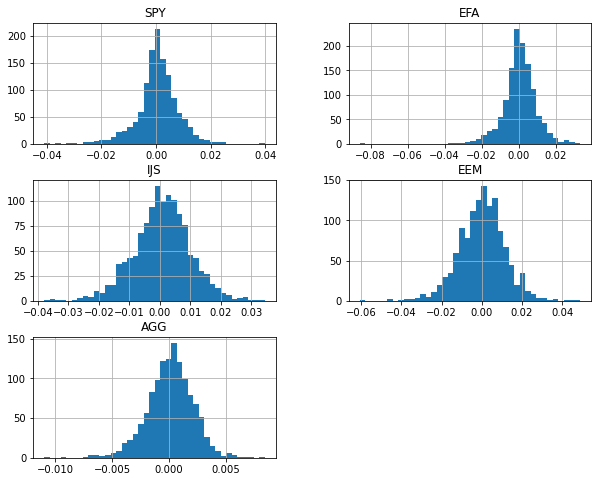

In [2]:
rets = raw.pct_change().dropna()

rets.hist(bins=40, figsize=(10, 8));

In [3]:
rets.describe()

,SPY,EFA,IJS,EEM,AGG
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000
mean,0.000610,0.000324,0.000617,0.000196,0.000078
std,0.007476,0.008985,0.009497,0.011567,0.002033
min,-0.040885,-0.085860,-0.037902,-0.060702,-0.010933
25%,-0.002778,-0.003991,-0.005131,-0.006799,-0.001094
50%,0.000632,0.000480,0.000771,0.000514,0.000180
75%,0.004652,0.005323,0.006543,0.007371,0.001375
max,0.039791,0.033264,0.034437,0.049041,0.008395


In [8]:
## Part 2

noa = 5

ann_rets = rets.mean() * 252

def port_ret(weights):
    return np.sum(ann_rets * weights)

def port_vol(weights):
    return np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

def min_func_sharpe(weights):  
    return -port_ret(weights) / port_vol(weights)  

cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})  

bnds = tuple((0, 1) for x in range(noa))  

eweights = np.array(noa * [1. / noa,])  
eweights  

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [9]:
opt_max_sharpe = sco.minimize(min_func_sharpe, eweights,
                    method='SLSQP', bounds=bnds,
                    constraints=cons) 

opt_max_sharpe

     fun: -1.542449933924015
     jac: array([ 6.55353069e-05,  1.96255074e+00,  2.27098018e-02,  3.73111834e+00,
       -3.01599503e-05])
 message: 'Optimization terminated successfully'
    nfev: 63
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([0.31534413, 0.        , 0.        , 0.        , 0.68465587])

In [10]:
## Part 3
opt_gmv = sco.minimize(port_vol, eweights,
                    method='SLSQP', bounds=bnds,
                    constraints=cons)  

opt_gmv

     fun: 0.029385486464908465
     jac: array([0.02938449, 0.03610563, 0.02938611, 0.05965359, 0.02938555])
 message: 'Optimization terminated successfully'
    nfev: 48
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([7.61477833e-02, 0.00000000e+00, 2.49941077e-02, 2.25514052e-17,
       8.98858109e-01])

In [16]:
type(opt_gmv.x)

numpy.ndarray

In [17]:
opt_gmv.x

array([7.61477833e-02, 0.00000000e+00, 2.49941077e-02, 2.25514052e-17,
       8.98858109e-01])

In [22]:
## Part 5
# Calculate the weighted stock returns

rets_max_sharpe_weighted = rets.mul(opt_max_sharpe.x, axis=1)
rets_max_sharpe_weighted['portfolio'] = rets_max_sharpe_weighted.sum(axis=1)

rets_gmv_weighted = rets.mul(opt_gmv.x, axis=1)
rets_gmv_weighted['portfolio'] = rets_gmv_weighted.sum(axis=1)


In [23]:
## Part 6

#Non-Parametric VaRs

# Max Sharpe
ms_var_95 = np.percentile(rets_max_sharpe_weighted['portfolio'], 100 - 95)
ms_var_99 = np.percentile(rets_max_sharpe_weighted['portfolio'], 100 - 99)

# GMV
gmv_var_95 = np.percentile(rets_gmv_weighted['portfolio'], 100 - 95)
gmv_var_99 = np.percentile(rets_gmv_weighted['portfolio'], 100 - 99)

#Non-Parametric CVaRs

# Max Sharpe
ms_cvar_95= rets_max_sharpe_weighted['portfolio'][rets_max_sharpe_weighted['portfolio'] <= ms_var_95].mean()
ms_cvar_99= rets_max_sharpe_weighted['portfolio'][rets_max_sharpe_weighted['portfolio'] <= ms_var_99].mean()

# GMV
gmv_cvar_95= rets_gmv_weighted['portfolio'][rets_gmv_weighted['portfolio'] <= gmv_var_95].mean()
gmv_cvar_99= rets_gmv_weighted['portfolio'][rets_gmv_weighted['portfolio'] <= gmv_var_99].mean()


In [26]:
print(ms_var_95)
print(ms_var_99)

print(gmv_var_95)
print(gmv_var_99)

print(ms_cvar_95)
print(ms_cvar_99)

print(gmv_cvar_95)
print(gmv_cvar_99)

-0.0038548508433902426
-0.006916379920662253
-0.003061191051704274
-0.004827906051528234
-0.005709655868769628
-0.008939650191994348
-0.00429904702685905
-0.006682941051893548


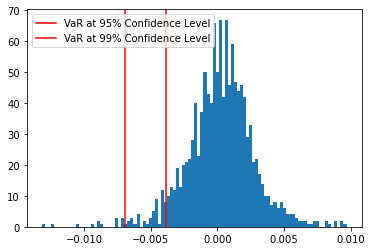

In [25]:
plt.hist(rets_max_sharpe_weighted['portfolio'], bins = 100)
plt.axvline(x = ms_var_95, c='r', label = "VaR at 95% Confidence Level")
plt.axvline(x = ms_var_99, c='r', label = "VaR at 99% Confidence Level")
plt.legend();

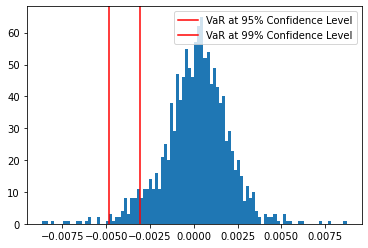

In [27]:
plt.hist(rets_gmv_weighted['portfolio'], bins = 100)
plt.axvline(x = gmv_var_95, c='r', label = "VaR at 95% Confidence Level")
plt.axvline(x = gmv_var_99, c='r', label = "VaR at 99% Confidence Level")
plt.legend();